## Tutorial 17 - Navier Stokes equations
**_Keywords: DEIM, supremizer operator_**

### 1. Introduction

In this tutorial, we will study the Navier-Stokes equations over the two-dimensional backward-facing step domain $\Omega$ shown below:

<img src="data/backward_facing_step.png" width="80%"/>

A Poiseuille flow profile is imposed on the inlet boundary, and a no-flow (zero velocity) condition is imposed on the walls. A homogeneous Neumann condition of the Cauchy stress tensor is applied at the outflow boundary.

The inflow velocity boundary condition is characterized by $$\boldsymbol{u}(\boldsymbol{x};\mu)=\mu\bigg \{\frac{1}{2.25}(x_1-2)(5-x_1),0\bigg \} \quad \forall \boldsymbol{x}=(x_0,x_1) \in \Omega$$ 

This problem is characterized by one parameter $\mu$, which characterizes the inlet velocity. The range of $\mu$ is the following $$\mu \in [1.0, 80.0].$$ 

Thus, the parameter domain is $$\mathbb{P}=[1.0,80.0].$$

In order to obtain a faster approximation of the problem, we pursue a model reduction by means of a POD-Galerkin reduced order method.


### 2. Parametrized formulation

Let $\boldsymbol{u}(\mu)$ be the velocity vector and $p(\mu)$ be the pressure in the domain $\Omega$.

We will directly provide a weak formulation for this problem: <center>for a given parameter $\mu \in \mathbb{P},$ find $u(\mu) \in \mathbb{V}(\mu), \; p \in\mathbb{M}$ such that </center>
    
<center>
    $
    \begin{cases}
        \nu \int_{\Omega} \nabla \boldsymbol{u} : \nabla \boldsymbol{v} \ d\Omega + \int_{\Omega} [(\boldsymbol{u} \cdot \nabla) \boldsymbol{u}] \cdot \boldsymbol{v} \ d\Omega - \int_{\Omega} p \nabla \cdot \boldsymbol{v} \ d\Omega = \int_{\Omega} \boldsymbol{f} \cdot \boldsymbol{v} \ d\Omega, \quad \forall \boldsymbol{v} \in\mathbb{V},  \\
        \int_{\Omega} q \nabla \cdot \boldsymbol{u} \ d\Omega = 0, \quad \forall q \in\mathbb{M}
    \end{cases}
    $
</center>    
where

* $\nu$ represents kinematic viscosity
* the functional space $\mathbb{V}(\mu)$ is defined as $\mathbb{V}=[H^1_{\Gamma_{wall}}(\Omega)]^2$
* the functional space $\mathbb{M}(\mu)$ is defined as $\mathbb{M}=L^2(\Omega)$


Since this problem utilizes mixed finite element discretization with the velocity and pressure as solution variables, the inf-sup condition is necessary for the well posedness of this problem. Thus, the supremizer operator $T^{\mu}: \mathbb{M}_h \rightarrow \mathbb{V}_h$ will be used.


In [1]:
from ufl import transpose
from dolfin import *
from rbnics import *

import sys
sys.path.append("../../MLniCS/")


from mlnics import NN, Losses, Normalization
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

### 3. Affine Decomposition 



In [2]:
@DEIM("online", basis_generation="Greedy")
@ExactParametrizedFunctions("offline")
class NavierStokes(NavierStokesProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NavierStokesProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        dup = TrialFunction(V)
        (self.du, self.dp) = split(dup)
        (self.u, _) = split(self._solution)
        vq = TestFunction(V)
        (self.v, self.q) = split(vq)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        #
        self.inlet = Expression(("1. / 2.25 * (x[1] - 2) * (5 - x[1])", "0."), degree=2)
        self.f = Constant((0.0, 0.0))
        self.g = Constant(0.0)
        # Customize nonlinear solver parameters
        self._nonlinear_solver_parameters.update({
            "linear_solver": "mumps",
            "maximum_iterations": 20,
            "report": True
        })

    # Return custom problem name
    def name(self):
        return "NavierStokesDEIM1"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    @compute_theta_for_supremizers
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.
            return (theta_a0,)
        elif term in ("b", "bt"):
            theta_b0 = 1.
            return (theta_b0,)
        elif term == "c":
            theta_c0 = 1.
            return (theta_c0,)
        elif term == "f":
            theta_f0 = 1.
            return (theta_f0,)
        elif term == "g":
            theta_g0 = 1.
            return (theta_g0,)
        elif term == "dirichlet_bc_u":
            theta_bc00 = mu[0]
            return (theta_bc00,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    @assemble_operator_for_supremizers
    def assemble_operator(self, term):
        dx = self.dx
        if term == "a":
            u = self.du
            v = self.v
            a0 = inner(grad(u) + transpose(grad(u)), grad(v)) * dx
            return (a0,)
        elif term == "b":
            u = self.du
            q = self.q
            b0 = - q * div(u) * dx
            return (b0,)
        elif term == "bt":
            p = self.dp
            v = self.v
            bt0 = - p * div(v) * dx
            return (bt0,)
        elif term == "c":
            u = self.u
            v = self.v
            c0 = inner(grad(u) * u, v) * dx
            return (c0,)
        elif term == "f":
            v = self.v
            f0 = inner(self.f, v) * dx
            return (f0,)
        elif term == "g":
            q = self.q
            g0 = self.g * q * dx
            return (g0,)
        elif term == "dirichlet_bc_u":
            bc0 = [DirichletBC(self.V.sub(0), self.inlet, self.boundaries, 1),
                   DirichletBC(self.V.sub(0), Constant((0.0, 0.0)), self.boundaries, 2)]
            return (bc0,)
        elif term == "inner_product_u":
            u = self.du
            v = self.v
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        elif term == "inner_product_p":
            p = self.dp
            q = self.q
            x0 = inner(p, q) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NavierStokesProblem)
def CustomizeReducedNavierStokes(ReducedNavierStokes_Base):
    class ReducedNavierStokes(ReducedNavierStokes_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNavierStokes_Base.__init__(self, truth_problem, **kwargs)
            self._nonlinear_solver_parameters.update({
                "report": True,
                "line_search": "wolfe"
            })

    return ReducedNavierStokes

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/backward_facing_step.xml")
subdomains = MeshFunction("size_t", mesh, "data/backward_facing_step_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/backward_facing_step_facet_region.xml")

### 4.2. Create Finite Element Space (Taylor-Hood P2-P1)

In [4]:
element_u = VectorElement("Lagrange", mesh.ufl_cell(), 2)
element_p = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
element = MixedElement(element_u, element_p)
V = FunctionSpace(mesh, element, components=[["u", "s"], "p"])

### 4.3. Allocate an object of the NavierStokes class

In [5]:
problem = NavierStokes(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(1.0, 80.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(10, DEIM=20)

### 4.5. Perform the offline phase

In [7]:
lifting_mu = (1.0,)
problem.set_mu(lifting_mu)
reduction_method.initialize_training_set(100, DEIM=144, sampling=EquispacedDistribution())
reduced_problem = reduction_method.offline()

In [8]:
net = NN.RONN(problem, reduction_method)

reduction_method.initialize_testing_set(16, DEIM=25, sampling=EquispacedDistribution())
test_mu, val_mu = NN.get_test_validation(net, validation_proportion=0.2)

In [9]:
input_normalization = Normalization.IdentityNormalization()
output_normalization = Normalization.IdentityNormalization()

In [10]:
pdnn_loss = Losses.PDNN_Loss(net, output_normalization)
pinn_loss = Losses.PINN_Loss(net)
prnn_loss = Losses.PRNN_Loss(net, output_normalization, omega=1.)

In [16]:
NN.normalize_and_train(net, pinn_loss, input_normalization, 
                       lr=0.00001, epochs=10000, validation_set=val_mu)

0 740.0955817550738 	mean error(validation) = 0.9513434210223265
100 739.7062596254715 	mean error(validation) = 0.9514074306521151
200 739.0838142567795 	mean error(validation) = 0.9514495910669981
300 738.3046412018516 	mean error(validation) = 0.9514993766173688
400 737.4046392956827 	mean error(validation) = 0.9515482477993721
500 736.3978750175966 	mean error(validation) = 0.9516004917601627
600 735.2937474655942 	mean error(validation) = 0.9516562556976785
700 734.102932396692 	mean error(validation) = 0.9517112725947469
800 732.8324091372658 	mean error(validation) = 0.951763365108283
900 731.4837677328406 	mean error(validation) = 0.9518138193480826
1000 730.0645371052519 	mean error(validation) = 0.9518628753905553
1100 728.5775842308391 	mean error(validation) = 0.9519095745110318
1200 727.0264607422982 	mean error(validation) = 0.9519536514297725
1300 725.4114066410798 	mean error(validation) = 0.9520041674735541
1400 723.7400991046597 	mean error(validation) = 0.95205322424

### 4.6. Perform an online solve

In [21]:
online_mu = (10.0,)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()
print(reduced_solution)

[ 1.00000000e+01 -4.34377478e+00 -4.22445533e+00 -2.89023164e+00
 -1.28133578e+00 -3.74364512e-01 -4.20034227e-02 -3.38750699e-02
 -1.60890210e-02  2.38390877e-04 -2.50425992e-03  1.62558677e-14
 -1.32983307e-14 -4.28210008e-14 -4.06108242e-14 -4.19999723e-14
 -1.32492865e-14  5.44554305e-15  5.47412738e-15  7.52416860e-16
  4.18352194e-15 -1.89865569e+02 -8.65698709e+01 -6.26082398e+01
 -1.65623894e+01 -2.94987661e+00  1.66636515e-01 -3.62992198e-01
 -8.30752637e-02 -1.48586105e-02 -1.29722978e-02]


In [22]:
net.eval()

with torch.no_grad():
    online_mu_nn = torch.tensor(online_mu)
    # NOTE: Change output_normalization accordingly for the different losses
    reduced_solution_nn = net.solve(online_mu_nn, input_normalization, output_normalization=None)
    print(reduced_solution_nn)
net.train()

[ 3.95357132e+00 -4.78356934e+00 -4.45297718e+00 -3.03767586e+00
 -1.23978639e+00 -5.04086316e-01 -2.49053463e-01  1.91195235e-01
  3.17301676e-02 -1.49965182e-01 -9.97740626e-02 -2.05994549e+01
 -6.31848431e+00  2.19996691e+00 -3.38193941e+00  5.14799261e+00
  1.64279759e-01 -2.03590512e+00  2.10805321e+00 -7.37039745e-01
  1.27576447e+00  9.01619186e+01 -4.25082283e+01 -4.61380100e+00
  9.27720642e+00  3.11138296e+00  3.31884027e+00 -3.24851346e+00
 -8.89748955e+00  1.68805763e-01 -1.68508613e+00]


RONN(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=31, bias=True)
  )
)

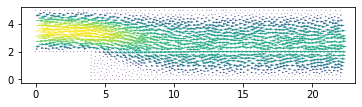

In [23]:
plot(reduced_solution, reduced_problem=reduced_problem, component="u")

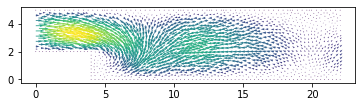

In [24]:
plot(reduced_solution_nn, reduced_problem=reduced_problem, component="u")

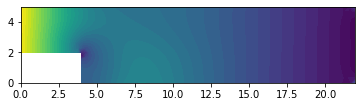

In [25]:
plot(reduced_solution, reduced_problem=reduced_problem, component="p")

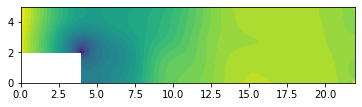

In [26]:
plot(reduced_solution_nn, reduced_problem=reduced_problem, component="p")

### 4.7. Perform an error analysis

In [ ]:
reduction_method.initialize_testing_set(16, DEIM=25, sampling=EquispacedDistribution())
reduction_method.error_analysis()

### 4.8. Perform a speedup analysis

In [ ]:
reduction_method.speedup_analysis()